### 01. Importing Libraries

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

### 02. Importing found data set

In [2]:
# Configure API key

quandl.ApiConfig.api_key = 'NzfhPitXNXGgRW6hqxcs'

In [3]:
# Importing the Federal Reserve Economic Data "Gross Domestic Product" variable. Using the GDP of the US since in my original
# data set, a country's GDP is used to determine their Economic Score.

data = quandl.get('FRED/GDP')

In [4]:
data.head()

,Value
Date,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742


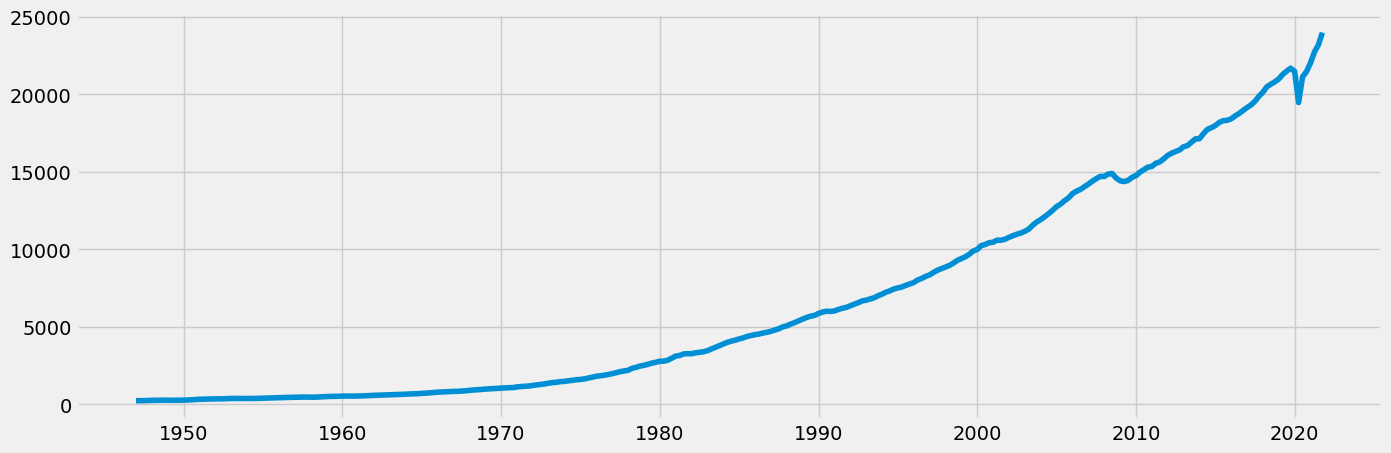

In [5]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

### 03. Subsetting

In [6]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [7]:
# Filtering data using loc function

data_sub = data_2.loc[(data_2['Date'] >= '2015-01-01') & (data_2['Date'] < '2021-12-31')]

In [11]:
# Check

data_sub.head(30)

,Date,Value
272,2015-01-01,17991.348
273,2015-04-01,18193.707
274,2015-07-01,18306.960
275,2015-10-01,18332.079
276,2016-01-01,18425.306
277,2016-04-01,18611.617
278,2016-07-01,18775.459
279,2016-10-01,18968.041
280,2017-01-01,19153.912
281,2017-04-01,19322.920


#### Chose to look at data that corresponded with the years of data I had in my original data set for my final project. My final project data started with 2015, so I began there, and looked at data up until the end of 2021 since the data I have on 2022 is an estimate.


In [12]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2015-01-01,17991.348
2015-04-01,18193.707
2015-07-01,18306.960
2015-10-01,18332.079
2016-01-01,18425.306


### 04. Plotting the new data set

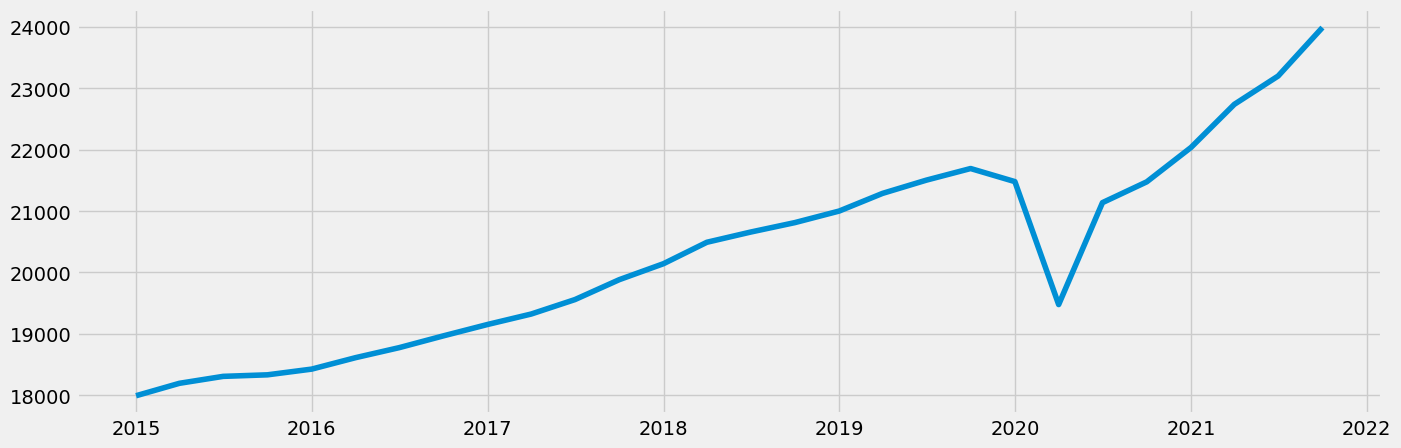

In [13]:
# Line graph of new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

### 05. Decompose the data’s components

In [14]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [15]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

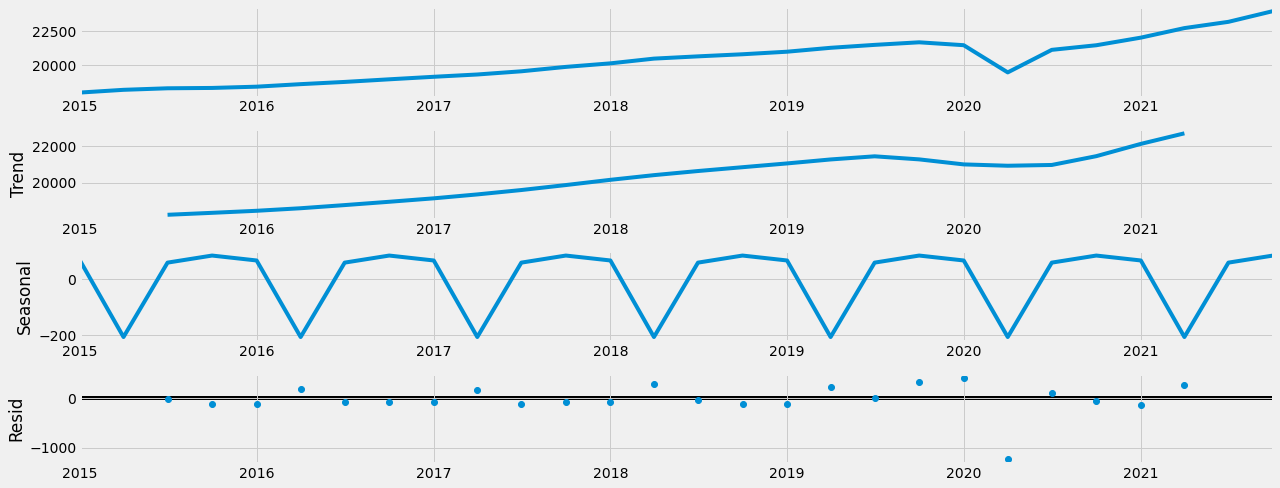

In [16]:
# Plot the separate components

decomposition.plot()
plt.show()

#### Since the data didn't need to be smoothed, the level and trend look similar. The dominant trend is one of steady growth. The impact of COVID is evident but things begin to pick back up not long after the initial shutdown. There are seasonal fluctuations at regular intervals and not much noise, aside from the initial impact of COVID. 

### 06. Conduct a Dickey-Fuller test to check for stationarity

In [17]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return
# an array of numbers. I need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
        result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  0.048330
p-value                         0.962351
Number of Lags Used             0.000000
Number of Observations Used    27.000000
Critical Value (1%)            -3.699608
Critical Value (5%)            -2.976430
Critical Value (10%)           -2.627601
dtype: float64


#### Test Statistic of 0.048330 is greater than Critical Value so null hypothesis can't be rejected. Null hypothesis states that there is the presence of a unit root and since it can't be rejected then it means the data is non-stationary.

### 09. Check your data’s autocorrelations

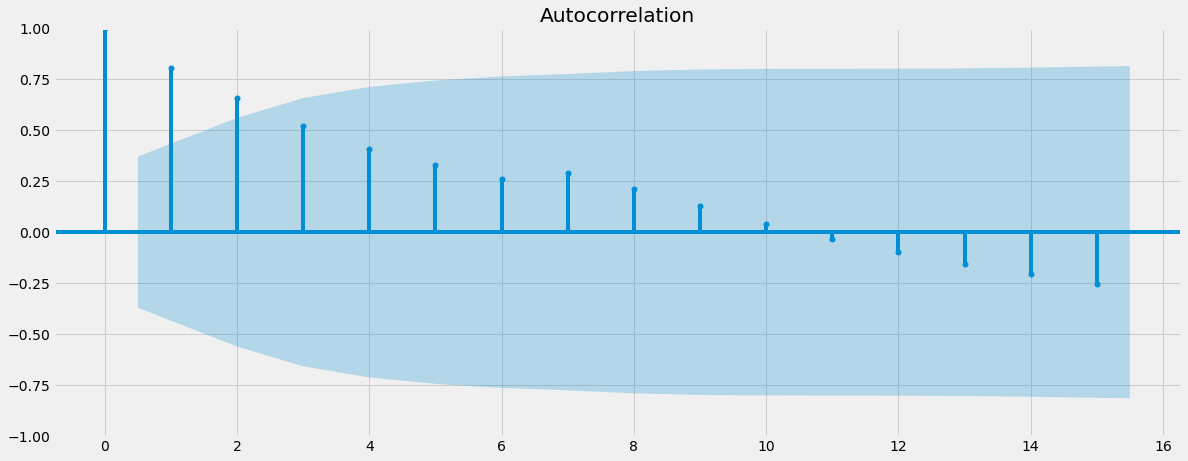

In [18]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(data_sub)
plt.show()

In [19]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [20]:
data_diff.dropna(inplace = True) # Here, I removed the missing values that came about as a result of the differencing.
# I need to remove these or I won't be able to run the Dickey-Fuller test.

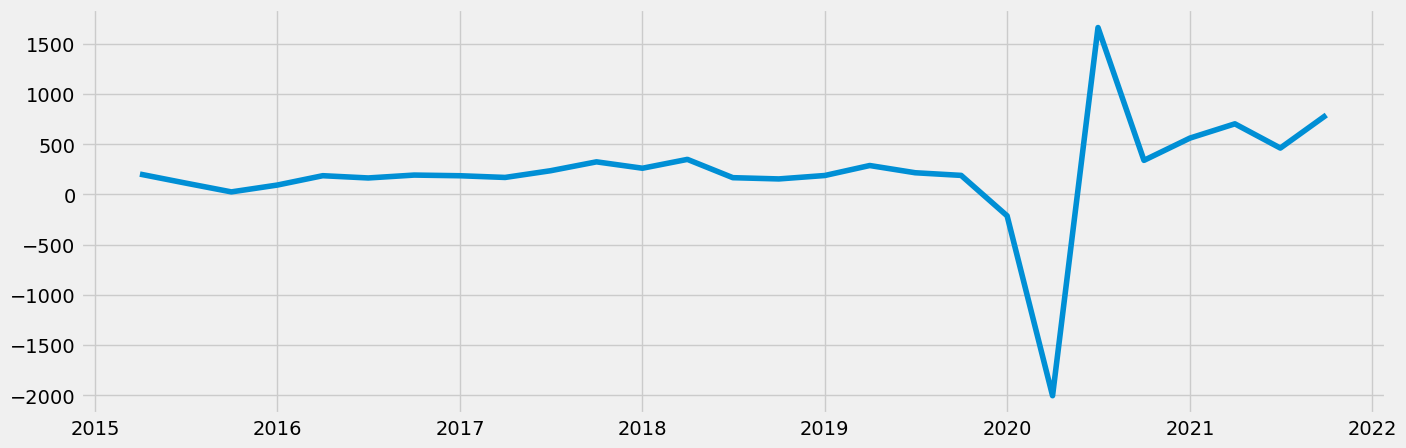

In [21]:
# The differencing affected the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [22]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -2.944628
p-value                         0.040399
Number of Lags Used             9.000000
Number of Observations Used    17.000000
Critical Value (1%)            -3.889266
Critical Value (5%)            -3.054358
Critical Value (10%)           -2.666984
dtype: float64


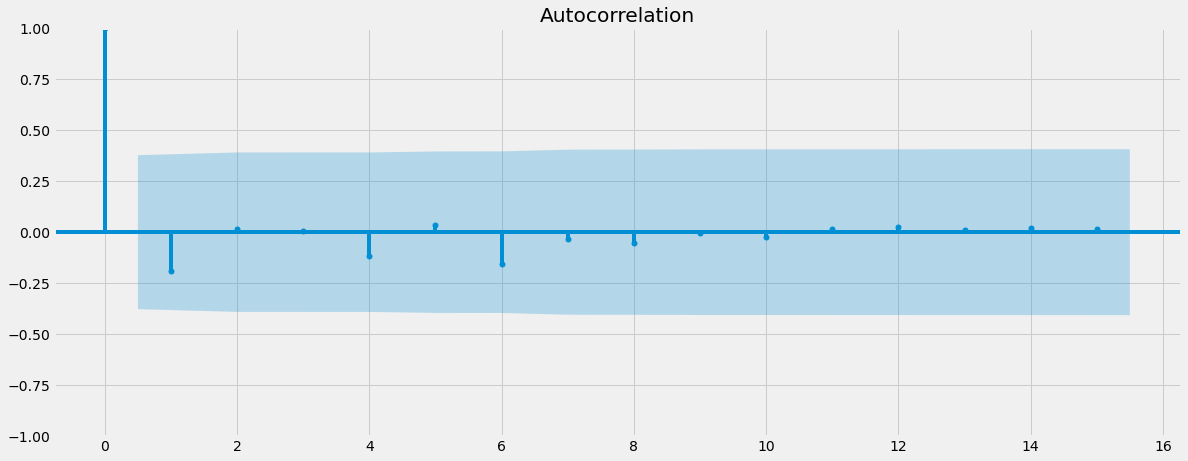

In [23]:
plot_acf(data_diff)
plt.show()

# End